[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Exploring PECD4.2 aggregated energy data for different Onshore Wind Power technologies

In the following Notebook, we will have a look at spatially aggregated data (CSV format) from one of the available energy indicators of the Pan-European Climate Database version 4.2 (PECD4.2): the onshore wind generation (WON) at the PEON (PECD onshore regions) level. We will focus on comparing three different wind generation technologies, considering one year (2020) of data from the historical stream (1950 to present). Note that, in principle, the analyses could be extended to consider more years and also climate projections (2015-2100).

After downloading the needed data from the CDS, we will visualize it by generating two types of figures that will help us compare the different technologies:

*   line plots: useful to visualize one or more time series;

*   histograms: useful to compare the distribution of low/high wind power generation values

All the code will be in Python.

## Learning objectives 🎯

Throughout this notebook, you will learn how to quickly download and read the PECD 4.2 CSV files and organize them into tables (DataFrames). You will also learn how to select a single column of your DataFrame (a single PECD region). You will learn how to produce a figure to show one or multiple time series, as well as a figure to visualize histograms to compare different wind power technologies.
Along the way, you'll get familiar with different wind power technologies, as well as some key Python libraries that will be useful for more complex operations and/or visualizations with PECD4.2 data.

## Prepare your environment

### Import required packages

We start by importing some useful libraries. These include: [os](https://docs.python.org/3/library/os.html), which provides a way to interact with the operating system and it is used here to manipulate paths; [pandas](https://pandas.pydata.org/), one of the most common and easy to use tools for data analysis and manipulation; [numpy](https://numpy.org/doc/stable/), fundamental for numerical computing; [matplotlib](https://matplotlib.org/), a standard library for creating visualizations in Python; [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) a service providing programmatic access to CDS that will allow you to download data for this analysis.

In [ ]:
# importing libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import cdsapi

### Set up the CDS API and your credentials

This step is essential to be able to download the data. To learn how to use the CDS API, see the [official guide](https://cds.climate.copernicus.eu/how-to-api). If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.
Alternatively, you can replace None in the following code cell with your API Token that can be found on the CDS portal at the address: https://cds.climate.copernicus.eu/profile (you will need to log in to see your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [2]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

To prepare the download code cell, you can build an api request using the CDS interface at the following link https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=download to easily specify the details of the needed data, by ticking the right boxes.

In this example, we will consider 'PECD4.2' data for the 'Historical' temporal stream (coming from 'ERA5 reanalysis' climate data). The variable we can select is the 'Wind power onshore capacity factor', from which we can select three different technologies:
- Tech type 30: Existing wind technologies (i.e., 2020 wind fleet).
- Tech type 35: New wind installations, with specific power (SP) of 277 W/m² and hub height (HH) of 150 m (short: SP277 HH150).
- Tech type 37: New wind installations, with specific power (SP) of 335 W/m² and hub height (HH) of 100 m (short: SP335 HH100).
We can also specify the Resource Grade, meaning the energy scenario. This will reflect wind capacity factors simulated for specific future installation sites:
- Resource Grade A: top 10% of locations with the highest wind energy potential.
- Resource Grade B: locations ranked within the 10–50% range in terms of wind resource potential.

In this example, we'll select 'Resource Grade B'.

Once all this information is manually selected, at the end of the download form, click on "Show API request". This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook, as done below. Running this cell will then retrieve the data you requested and download it into your local directory.

In [3]:
# define our dataset
dataset = "sis-energy-pecd"

# dictionary of base request
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "variable": ["wind_power_onshore_capacity_factor"],
    "technology": [
        "30",
        "35",
        "37"
    ],
    "energy_scenario": ["resource_grade_b"],
    "spatial_resolution": ["peon"],
    "year": ["2020"]
}

Before running the download we can make sure there's a dedicated folder ready to host the data.

In [4]:
input_dir = "cds_data"
os.system(f"mkdir -p {input_dir}")

0

Now that it is all set, we are ready to download the data.

In [5]:
# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/test.zip")

2025-07-03 13:19:19,874 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-03 13:19:26,592 INFO Request ID is 00c7ed6e-ddff-419d-970f-54e7905a75f7
2025-07-03 13:19:26,924 INFO status has been updated to accepted
2025-07-03 13:19:40,426 INFO status has been updated to running
2025-07-03 13:19:48,448 INFO status has been updated to successful


9d8f94347ab4ee8279c98380d590f58b.zip:   0%|          | 0.00/8.39M [00:00<?, ?B/s]

'cds_data/test.zip'

Since our data are inside zipped files we need to unzip them. The final csv files will have a name according to the naming conventions of Pan-European Climate Database. You can find the explanation of the different fields in the production guide of the  PECD, at the following link: https://confluence.ecmwf.int/pages/viewpage.action?pageId=439598955#ClimateandenergyrelatedvariablesfromthePanEuropeanClimateDatabasederivedfromreanalysisandclimateprojections:Productuserguide(PUG)-Filenamesconventionandcharacteristics

In [6]:
# Unzipping every file in our folder
for fname in os.listdir(input_dir):
    if fname.endswith(".zip"):
        subfolder = fname.split('.')[0]
        os.system(f'unzip {input_dir}/{fname} -d {input_dir}')

Archive:  cds_data/test.zip
  inflating: cds_data/H_ERA5_ECMW_T639_WON_NA---_Pecd_PEON_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_30_NA---_ReGrB_PhM04_PECD4.2_fv1.csv  
  inflating: cds_data/H_ERA5_ECMW_T639_WON_NA---_Pecd_PEON_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_35_NA---_ReGrB_PhM04_PECD4.2_fv1.csv  
  inflating: cds_data/H_ERA5_ECMW_T639_WON_NA---_Pecd_PEON_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_37_NA---_ReGrB_PhM04_PECD4.2_fv1.csv  


## Load the data

Once the data is unzipped, it is ready to be loaded with Pandas: the analysis can begin!

In [7]:
# Load generation data for the different wind technology types.
# tech type 30
fname = ("H_ERA5_ECMW_T639_WON_NA---_Pecd_PEON_S202001010000_E202012312300" +
         "_CFR_TIM_01h_COM_noc_org_30_NA---_ReGrB_PhM04_PECD4.2_fv1.csv")
file_path = os.path.join(input_dir, fname)
df_Existing = pd.read_csv(file_path, comment='#', index_col=['Date'], parse_dates=['Date'])

# tech type 35
fname = ("H_ERA5_ECMW_T639_WON_NA---_Pecd_PEON_S202001010000_E202012312300" +
         "_CFR_TIM_01h_COM_noc_org_35_NA---_ReGrB_PhM04_PECD4.2_fv1.csv")
file_path = os.path.join(input_dir, fname)
df_SP277_HH150 = pd.read_csv(file_path, comment='#', index_col=['Date'], parse_dates=['Date'])

# tech type 37
fname = ("H_ERA5_ECMW_T639_WON_NA---_Pecd_PEON_S202001010000_E202012312300" +
         "_CFR_TIM_01h_COM_noc_org_37_NA---_ReGrB_PhM04_PECD4.2_fv1.csv")
file_path = os.path.join(input_dir, fname)
df_SP335_HH100 = pd.read_csv(file_path, comment='#', index_col=['Date'], parse_dates=['Date'])

## Plot the data

Now that we have three DataFrames with all the information, we can start exploring the data by plotting some time series to see how onshore wind (WON) generation time series differ between the different technologies.

### Plot a time series (line plot)

If we want to visualize a time series of WON for a single region, we need to specificy that region's code: in this example we'll select Central/Northern Sweden, with code 'SE02'. We'll plot the three technologies together in order to compare them.
Please remember that the PECD 4.2 data were downloaded just for one weather year (2020), but, in principle, the presented analyses can be extended to cover as many weather years as required.

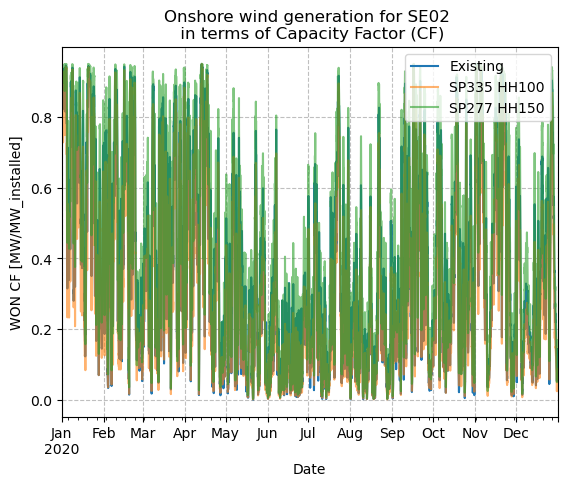

In [8]:
# Plot the 3 different wind technologies for region SE02.
region_to_plot = 'SE02'

df_Existing[region_to_plot].plot(label="Existing")
df_SP335_HH100[region_to_plot].plot(label="SP335 HH100", alpha=0.6)
df_SP277_HH150[region_to_plot].plot(label="SP277 HH150", alpha=0.6)
plt.legend(loc="upper right")
plt.ylabel('WON CF [MW/MW_installed]')
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.title(f'Onshore wind generation for {region_to_plot} \n in terms of Capacity Factor (CF)')

plt.show()
plt.close()

### Plot a time series with zoom

The previous plot shows the full one year data. It is not easy to see the different time series, so we may want to zoom in to better visualize the differences.
The following plot zoomes to a few days.

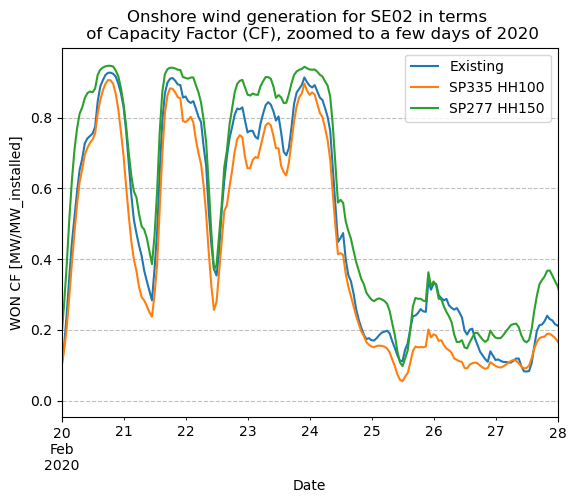

In [9]:
# Plot and zoom
df_Existing[region_to_plot].plot(label="Existing")
df_SP335_HH100[region_to_plot].plot(label="SP335 HH100")
df_SP277_HH150[region_to_plot].plot(label="SP277 HH150")
plt.legend(loc="upper right")
plt.ylabel('WON CF [MW/MW_installed]')
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.title(f'Onshore wind generation for {region_to_plot} in terms \n' +
          ' of Capacity Factor (CF), zoomed to a few days of 2020')

start_date = '2020-02-20'
end_date = '2020-02-28'
plt.xlim(start_date, end_date)

plt.show()
plt.close()

The zoomed plot shows that all three technologies follow roughly the same pattern of high and low wind generation time periods. This can be expected as all technologies are located in the same region. However, we can see that the SP277 HH150 type generation is consistently higher than with SP335 HH100. This is because SP277 HH150 has a higher hub height (HH) and lower specific power (SP). Lower SP means that the rotor is larger in proportion to the generator, indicating higher generation at the same wind speed.

### Plot histogram

Histograms are often used to get an overview of high/low generation probabilities. They also provide interesting information when comparing different wind technologies.
In addition to histograms, we calculate annual capacity factors (CFs) to compare the different technologies.

Annual capacity factor for Existing tech = 0.36640630692167575
Annual capacity factor for SP335 HH100 = 0.3114245787795993
Annual capacity factor for SP277 HH150 = 0.44542312158469943


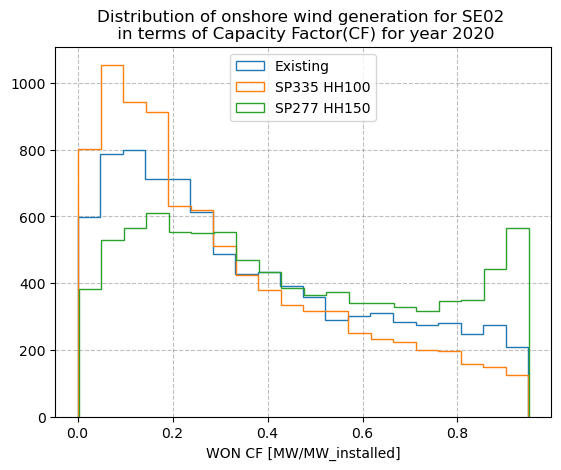

In [10]:
# plot the full year of data as a histogram and calculate average annual capacity factors
df_Existing[region_to_plot].hist(label="Existing", bins=20, histtype='step')
df_SP335_HH100[region_to_plot].hist(label="SP335 HH100", bins=20, histtype='step')
df_SP277_HH150[region_to_plot].hist(label="SP277 HH150", bins=20, histtype='step')
plt.legend(loc="upper center")
plt.xlabel('WON CF [MW/MW_installed]')
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.title(f'Distribution of onshore wind generation for {region_to_plot} \n' +
          ' in terms of Capacity Factor(CF) for year 2020')

CF_Existing = df_Existing[region_to_plot].mean()
CF_SP335_HH100 = df_SP335_HH100[region_to_plot].mean()
CF_SP277_HH150 = df_SP277_HH150[region_to_plot].mean()

print(f'Annual capacity factor for Existing tech = {CF_Existing}')
print(f'Annual capacity factor for SP335 HH100 = {CF_SP335_HH100}')
print(f'Annual capacity factor for SP277 HH150 = {CF_SP277_HH150}')

It can be seen that the annual CF of the existing technology for SE02 is in between the two future technologies. This makes sense as the average hub height of the existing wind installations in the region is around 115 m and specific power around 297 W/m²; i.e., both are between the HH and SP values of the simulated future technologies.

The following shows the same histograms as above but for the region DKW1 (Western Denmark).

Annual capacity factor for Existing tech = 0.2714757741347905
Annual capacity factor for SP335 HH100 = 0.3884317509107469
Annual capacity factor for SP277 HH150 = 0.49320754781420767


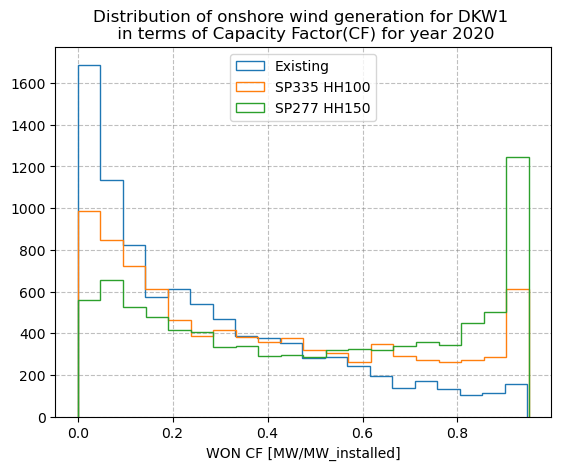

In [11]:
# plot the full year of data as a histogram and calculate average annual capaciy factors for region
region_to_plot = 'DKW1'

df_Existing[region_to_plot].hist(label="Existing", bins=20, histtype='step')
df_SP335_HH100[region_to_plot].hist(label="SP335 HH100", bins=20, histtype='step')
df_SP277_HH150[region_to_plot].hist(label="SP277 HH150", bins=20, histtype='step')
plt.legend(loc="upper center")
plt.xlabel('WON CF [MW/MW_installed]')
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.title(f'Distribution of onshore wind generation for {region_to_plot} \n' +
          ' in terms of Capacity Factor(CF) for year 2020')

CF_Existing = df_Existing[region_to_plot].mean()
CF_SP335_HH100 = df_SP335_HH100[region_to_plot].mean()
CF_SP277_HH150 = df_SP277_HH150[region_to_plot].mean()

print(f'Annual capacity factor for Existing tech = {CF_Existing}')
print(f'Annual capacity factor for SP335 HH100 = {CF_SP335_HH100}')
print(f'Annual capacity factor for SP277 HH150 = {CF_SP277_HH150}')

The existing technology for DKW1 shows lower annual CF than for SE02. This is because the existing fleet in DKW1 has much lower average hub height (67 m) and higher SP (389 W/m²) than SE02.
The future technologies show a significant CF increase for DKW1 when comparing to the existing installations, as the existing fleet is old, with low HH and high SP. Already the SP335 HH100 shows a large CF increase, indicating that new wind installations in western Denmark can signficantly increase the country-wise onshore wind capacity factor.

## Take home messages 📌

*   Energy data stored in CSV files can be easily read, explored, and summarized using pandas.
*   Time series can be plotted using matplotlib for visual comparison and it's easy to zoom in on a specific time window.
*   PECD4.2 wind power data comprises several technologies
*   Histograms and annual averages of the wind power capacity factors can help in comparing these different technologies.